# <center>Analyze Predictions' Intersection</center>

This notebook contains the code to:
- Analyze the intersections of different model's predictions.
- Plot a heatmap with the intersection of true/false positives.

In [1]:
import itertools as itt
import os
from pathlib import Path
import sys

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../')
from src import analysis

PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

# Load model predictions

In [2]:
best_trials_fn = os.path.join(PREDICTIONS_PATH, "all_best_trials.csv")

if os.path.exists(best_trials_fn):
    predictions = pd.read_csv(best_trials_fn, sep="\t")
else:
    prediction_files = [p for p in Path(PREDICTIONS_PATH).glob("preds_*-trial_0-test.csv")]

    predictions = []
    for csv in prediction_files:
        df = pd.read_csv(csv, sep="\t")
        df = df.sort_values("score", ascending=False).reset_index()
        predictions.append(df)
        
    predictions = pd.concat(predictions, ignore_index=True)

    predictions = predictions.rename({
        'head_label': 'source',
        'tail_label': 'target',
    }, axis=1)

    predictions = predictions[['kg', 'model', 'source', 'target', 'score']]
    predictions['trial_k'] = 0
    predictions = analysis.add_ground_truth(predictions)
    predictions.to_csv(best_trials_fn, sep="\t", index=False)

# Compute Intersection

In [3]:
def get_models_intersection(df, K_values, filter=None):
    fields = ['source', 'target', 'y', 'score']
    model_topologies = df.model.unique()
    results = df[['kg', 'model']+fields].copy()
    results = results.sort_values(['model', 'score'], ascending=[True, False])

    data = []
    for kg in results['kg'].unique():
        results_kg = results[results['kg'] == kg]
        for K in K_values:
            for model1, model2 in itt.product(model_topologies, model_topologies):
                df_model1 = results_kg[results_kg['model'] == model1][fields].head(K)
                df_model2 = results_kg[results_kg['model'] == model2][fields].head(K)

                df = pd.concat([df_model1, df_model2], ignore_index=True)
                preds = df.groupby(['source', 'target'])
                intersection = len(df)-len(preds)
                data.append([kg, K, model1, model2, intersection])

    headers = ['kg', 'K', 'model1', 'model2', 'intersection']
    models_intersection = pd.DataFrame(data, columns=headers)
    return models_intersection

In [4]:
predictions_tp = predictions[predictions['y'] == 1]
predictions_fp = predictions[predictions['y'] == 0]

intersection_tp_fn = os.path.join(PREDICTIONS_PATH, "intersection_tp.csv")
intersection_fp_fn = os.path.join(PREDICTIONS_PATH, "intersection_fp.csv")

if os.path.exists(intersection_tp_fn):
    intersection_tp = pd.read_csv(intersection_tp_fn, sep='\t')
else:
    intersection_tp = get_models_intersection(predictions_tp, K_values=[10, 100])
    intersection_tp.to_csv(intersection_tp_fn, sep='\t', index=False)
    
if os.path.exists(intersection_fp_fn):
    intersection_fp = pd.read_csv(intersection_fp_fn, sep='\t')
else:
    intersection_fp = get_models_intersection(predictions_fp, K_values=[10, 100])
    intersection_fp.to_csv(intersection_fp_fn, sep='\t', index=False)

# Plots

### Auxiliary functions

In [5]:
kg2title = {
    'openbiolink': 'OpenBioLink',
    'biokg': 'BioKG',
}


model2title = {
    'rescal': 'RESCAL',
    'transe': 'TransE',
    'distmult': 'DistMult',
    'ermlp': 'ERMLP',
    'transh': 'TransH',
    'complex': 'ComplEx',
    'hole': 'HolE',
    'conve': 'ConvE',
    'rotate': 'RotatE',
    'mure': 'MuRE',   
}

def plot_intersection_grid(data, kg, K_values, save_to):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

    for ax, (K, positive) in zip(axes.flatten(), itt.product(K_values, data.keys())):
        df = data[positive].copy()
        df['model1'] = df['model1'].apply(lambda x: model2title[x])
        df['model2'] = df['model2'].apply(lambda x: model2title[x])
        df_pivot = df[
            (df['kg'] == kg) & \
            (df['K'] == K)
        ].pivot("model1", "model2", "intersection")

        sns.heatmap(
            df_pivot,
            vmin=0,
            vmax=K,
            ax=ax,
        )
        ax.set_title(f"Top {K} {positive}", fontsize=14)
        ax.set_ylabel('')
        ax.set_xlabel('')
        
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.suptitle(f'Intersection of true positives vs. false positives among the TopK predicted links on {kg2title[kg]}', fontsize=18)
    plt.savefig(os.path.join(PLOTS_PATH, save_to))

In [6]:
data = {}
data['True Positives'] = intersection_tp
data['False Positives'] = intersection_fp

## OpenBioLink

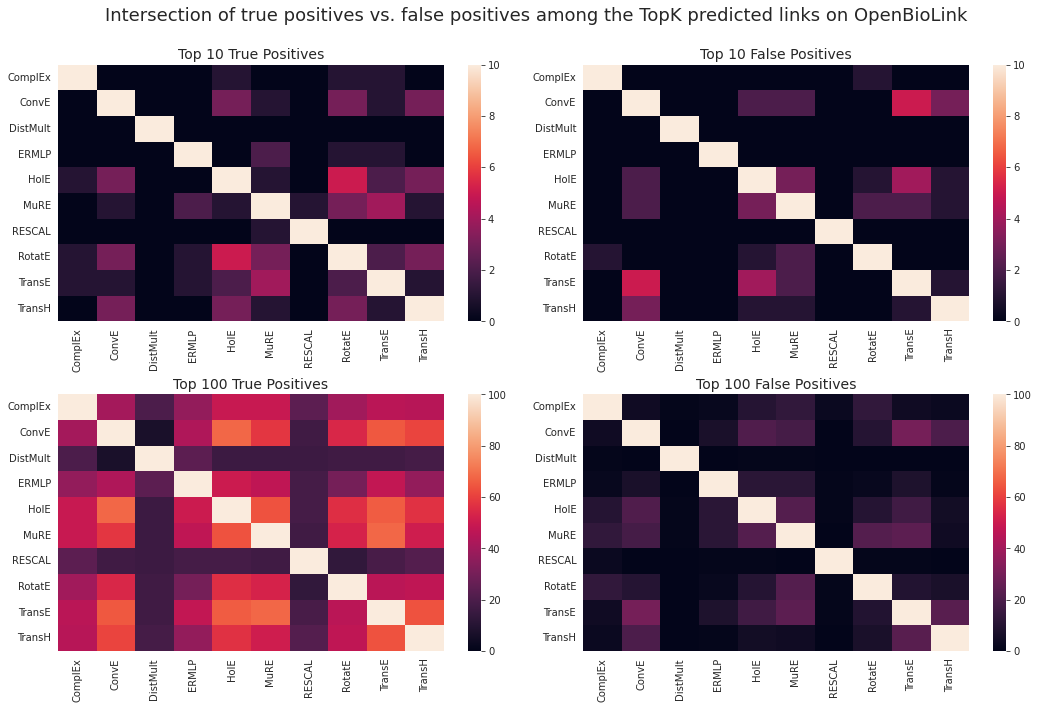

In [7]:
plot_intersection_grid(
    data=data,
    kg='openbiolink',
    K_values=[10, 100],
    save_to='tp_vs_fp-heatmap-openbiolink.png',
)

## BioKG

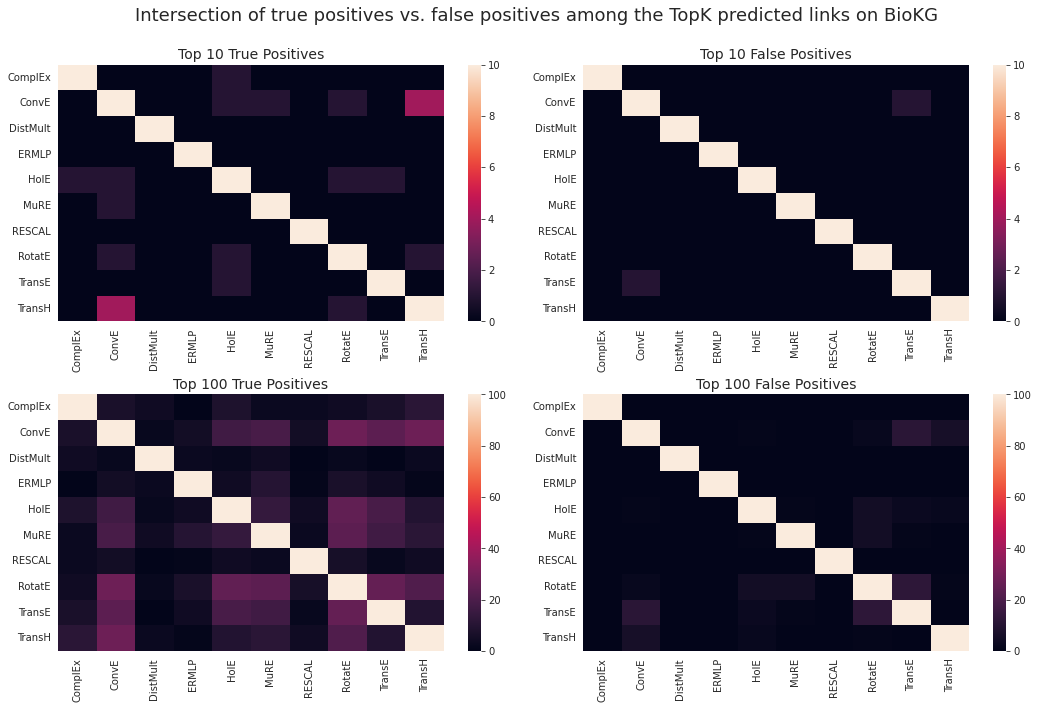

In [8]:
plot_intersection_grid(
    data=data,
    kg='biokg',
    K_values=[10, 100],
    save_to='tp_vs_fp-heatmap-biokg.png',
)